!["Facultad de Ingeniería de la UBA"](LogoFIUBA.jpg)

# Trabajo Final - Series de Tiempo 2
## **Análisis Comparativo de Modelos para Bitcoin Forecasting**
### _Universidad de Buenos Aires - Facultad de Ingeniería - LSE_

- **Carrera:** Maestría en Inteligencia Artificial  
- **Curso:** Análisis de Series de Tiempo II
- **Docentes:**
    - Camilo Argoty
    - Matías Vera
- **Grupo:**
    - Jorge Hernán Cuenca Marín *(a0805)*
    - Alejandro Lloveras *(a1716)*
    - Fabián Sarmiento *(2672002)*

In [1]:
# Importaciones
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# FORZAR RECARGA DEL MODULO ACTUALIZADO
if 'deep_learning_models' in sys.modules:
    del sys.modules['deep_learning_models']
    print("Modulo deep_learning_models eliminado del cache")

from deep_learning_models import (
    create_model,
    DeepLearningTrainer,
    TimeSeriesDataset,
    calculate_metrics as dl_calculate_metrics,
    device as torch_device
)

from stationarity_tests import analyze_series_and_differences

print(f"PyTorch: {torch.__version__}")
print(f"Device: {torch_device}")
print(f"CUDA: {torch.cuda.is_available()}")
print("Modulo deep_learning_models cargado correctamente")

# Config
CONFIG = {
    'ticker': 'BTC-USD',
    'start_date': '2020-01-01',
    'end_date': '2024-11-01',
    'train_ratio': 0.80,
    'forecast_horizons': [7, 14, 30],
    'dl_seq_len': 60,
    'dl_epochs': 50,
    'dl_batch_size': 32,
    'dl_learning_rate': 0.001,
    'dl_patience': 10,
    'output_dir': 'final_st2_results',
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)
print(f"\nResultados en: {CONFIG['output_dir']}/")

PyTorch: 2.9.0+cpu
Device: cpu
CUDA: False
Modulo deep_learning_models cargado correctamente

Resultados en: final_st2_results/


## 1. Carga de Datos

In [2]:
print("Descargando Bitcoin...")
data = yf.download(CONFIG['ticker'], 
                   start=CONFIG['start_date'], 
                   end=CONFIG['end_date'],
                   progress=False)

print(f"\nDatos: {len(data)} observaciones")
print(f"Periodo: {data.index[0].date()} a {data.index[-1].date()}")
print(f"\nPrimeras filas:")
data.head()

Descargando Bitcoin...

Datos: 1766 observaciones
Periodo: 2020-01-01 a 2024-10-31

Primeras filas:


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


In [3]:
# Estadisticas
print("ESTADISTICAS")
print(f"Precio inicial: ${float(data['Close'].iloc[0]):,.2f}")
print(f"Precio final:   ${float(data['Close'].iloc[-1]):,.2f}")
print(f"Precio minimo:  ${float(data['Close'].min()):,.2f}")
print(f"Precio maximo:  ${float(data['Close'].max()):,.2f}")
print(f"Precio promedio: ${float(data['Close'].mean()):,.2f}")

returns_total = ((float(data['Close'].iloc[-1]) / float(data['Close'].iloc[0])) - 1) * 100
print(f"\nRetorno total: {returns_total:+.2f}%")

daily_returns = data['Close'].pct_change().dropna()
volatility = float(daily_returns.std() * np.sqrt(252) * 100)
print(f"Volatilidad anualizada: {volatility:.2f}%")

ESTADISTICAS
Precio inicial: $7,200.17
Precio final:   $70,215.19
Precio minimo:  $4,970.79
Precio maximo:  $73,083.50
Precio promedio: $34,376.83

Retorno total: +875.19%
Volatilidad anualizada: 53.50%


In [4]:
# Train/Test split
split_idx = int(len(data) * CONFIG['train_ratio'])
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

print(f"Train: {len(train_data)} obs ({CONFIG['train_ratio']*100:.0f}%)")
print(f"Test:  {len(test_data)} obs ({(1-CONFIG['train_ratio'])*100:.0f}%)")

Train: 1412 obs (80%)
Test:  354 obs (20%)


## 2. Visualización EDA

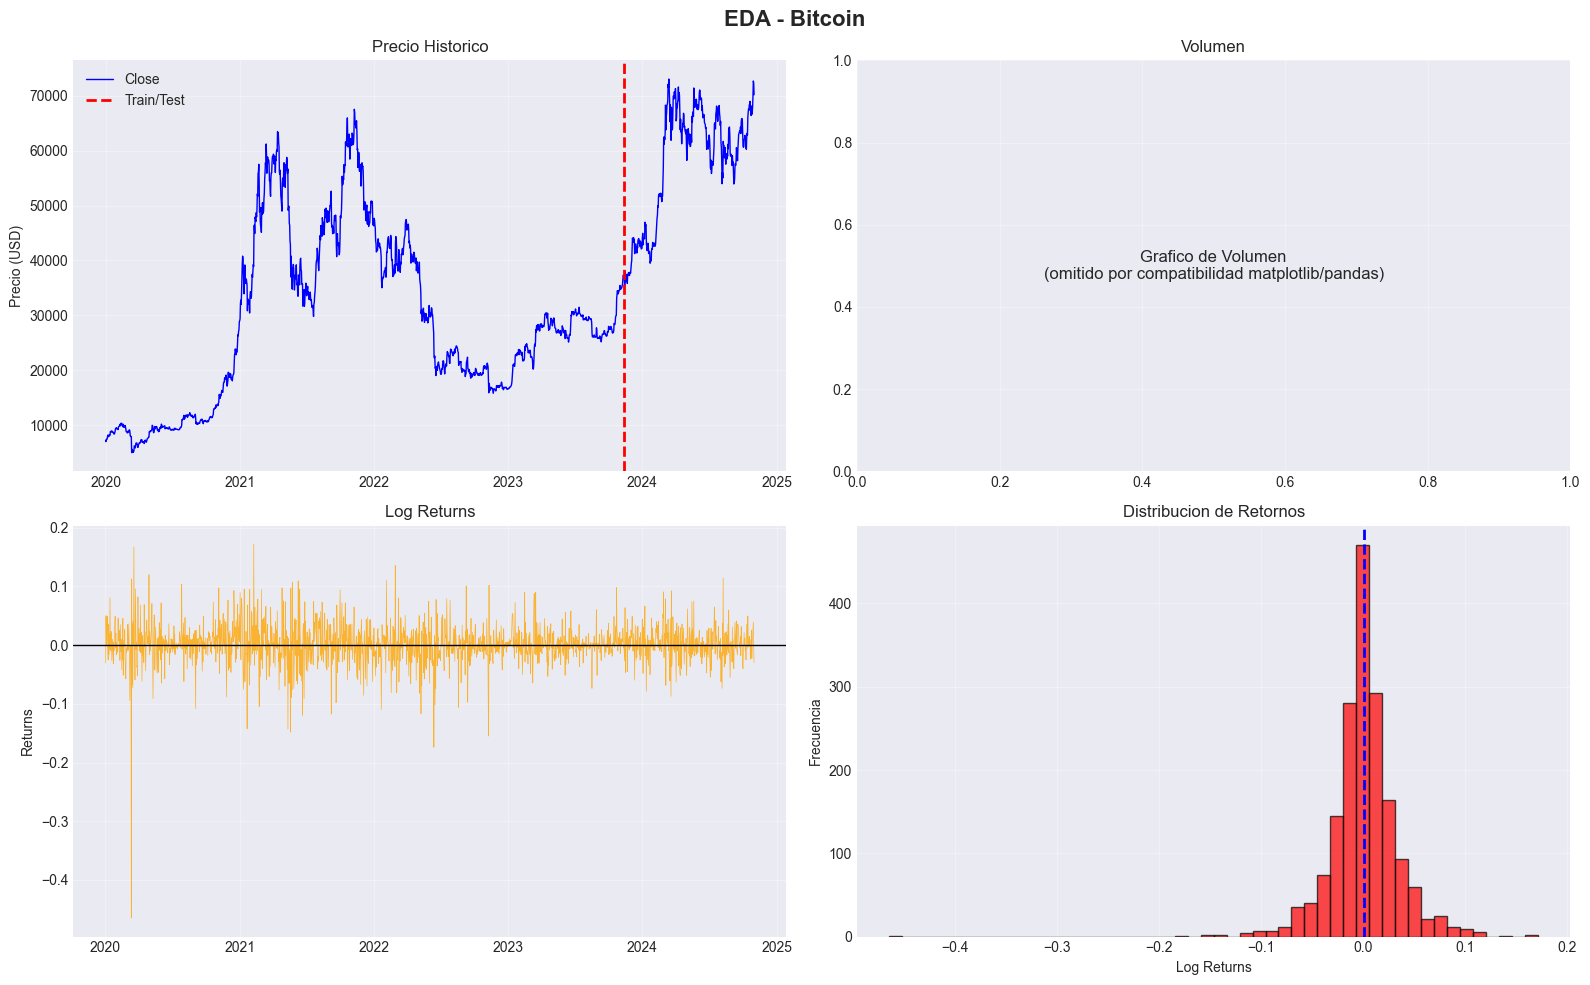

EDA guardado.


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('EDA - Bitcoin', fontsize=16, fontweight='bold')

# Precio
ax = axes[0, 0]
ax.plot(data.index, data['Close'].values, linewidth=1, color='blue', label='Close')
ax.axvline(train_data.index[-1], color='red', linestyle='--', linewidth=2, label='Train/Test')
ax.set_title('Precio Historico')
ax.set_ylabel('Precio (USD)')
ax.legend()
ax.grid(True, alpha=0.3)

# Volumen - OMITIDO (error matplotlib/pandas en Python 3.13)
ax = axes[0, 1]
ax.text(0.5, 0.5, 'Grafico de Volumen\n(omitido por compatibilidad matplotlib/pandas)', 
        ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.set_title('Volumen')
ax.grid(True, alpha=0.3)

# Retornos
ax = axes[1, 0]
returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
ax.plot(returns.index, returns.values, linewidth=0.5, color='orange', alpha=0.8)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_title('Log Returns')
ax.set_ylabel('Returns')
ax.grid(True, alpha=0.3)

# Distribucion
ax = axes[1, 1]
ax.hist(returns.values, bins=50, color='red', alpha=0.7, edgecolor='black')
ax.axvline(float(returns.mean()), color='blue', linestyle='--', linewidth=2)
ax.set_title('Distribucion de Retornos')
ax.set_xlabel('Log Returns')
ax.set_ylabel('Frecuencia')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{CONFIG['output_dir']}/01_EDA.png", dpi=300, bbox_inches='tight')
plt.show()
print("EDA guardado.")

## 3. Tests de Estacionariedad

In [6]:
print("TESTS DE ESTACIONARIEDAD")
print("="*60)

# Precios
print("\n[1] PRECIOS (nivel 0)")
adf_result = adfuller(data['Close'].dropna())
kpss_result = kpss(data['Close'].dropna(), regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'NO ESTACIONARIO' if adf_result[1] > 0.05 else 'ESTACIONARIO'}")

# Primera diferencia
print("\n[2] PRIMERA DIFERENCIA")
diff1 = data['Close'].diff().dropna()
adf_result = adfuller(diff1)
kpss_result = kpss(diff1, regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'ESTACIONARIO' if adf_result[1] < 0.05 else 'NO ESTACIONARIO'}")

# Log returns
print("\n[3] LOG RETURNS")
log_ret = np.log(data['Close'] / data['Close'].shift(1)).dropna()
adf_result = adfuller(log_ret)
kpss_result = kpss(log_ret, regression='ct')
print(f"ADF: statistic={adf_result[0]:.4f}, p-value={adf_result[1]:.4f}")
print(f"KPSS: statistic={kpss_result[0]:.4f}, p-value={kpss_result[1]:.4f}")
print(f"Conclusion: {'ESTACIONARIO' if adf_result[1] < 0.05 else 'NO ESTACIONARIO'}")

TESTS DE ESTACIONARIEDAD

[1] PRECIOS (nivel 0)
ADF: statistic=-1.0647, p-value=0.7289
KPSS: statistic=0.6489, p-value=0.0100
Conclusion: NO ESTACIONARIO

[2] PRIMERA DIFERENCIA
ADF: statistic=-44.0902, p-value=0.0000
KPSS: statistic=0.1060, p-value=0.1000
Conclusion: ESTACIONARIO

[3] LOG RETURNS
ADF: statistic=-13.7820, p-value=0.0000
KPSS: statistic=0.1445, p-value=0.0527
Conclusion: ESTACIONARIO


## 4. Modelo ARIMA

In [7]:
print("ARIMA - Auto seleccion")
best_aic = np.inf
best_order = None
best_model = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = ARIMA(train_data['Close'], order=(p,d,q))
                fitted = model.fit()
                if fitted.aic < best_aic:
                    best_aic = fitted.aic
                    best_order = (p,d,q)
                    best_model = fitted
            except:
                continue

print(f"Mejor orden: {best_order}")
print(f"AIC: {best_aic:.2f}")

arima_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    forecast = best_model.forecast(steps=horizon)
    actual = test_data['Close'].iloc[:horizon]
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    
    arima_forecasts[horizon] = {
        'forecast': forecast,
        'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    
    print(f"\nHorizonte {horizon}d: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")

print("\nARIMA completado.")

ARIMA - Auto seleccion
Mejor orden: (2, 1, 2)
AIC: 23897.66

Horizonte 7d: RMSE=839.75, MAE=727.62, R2=-0.3839

Horizonte 14d: RMSE=744.07, MAE=638.19, R2=-0.0146

Horizonte 30d: RMSE=3446.22, MAE=2392.03, R2=-0.5375

ARIMA completado.


## 5. Modelo SARIMA

In [8]:
print("SARIMA")
sarima_model = SARIMAX(train_data['Close'], 
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fitted = sarima_model.fit(disp=False)
print(f"AIC: {sarima_fitted.aic:.2f}")

sarima_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    forecast = sarima_fitted.forecast(steps=horizon)
    actual = test_data['Close'].iloc[:horizon]
    
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    r2 = r2_score(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    
    sarima_forecasts[horizon] = {
        'forecast': forecast,
        'actual': actual,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}
    }
    
    print(f"Horizonte {horizon}d: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")

print("\nSARIMA completado.")

SARIMA
AIC: 23679.88
Horizonte 7d: RMSE=818.40, MAE=713.79, R2=-0.3144
Horizonte 14d: RMSE=721.32, MAE=577.28, R2=0.0465
Horizonte 30d: RMSE=3181.76, MAE=2159.79, R2=-0.3105

SARIMA completado.


## 6. Preparacion Datos Deep Learning

In [9]:
print("Preparando datos DL...")

train_prices = train_data['Close'].values.reshape(-1, 1)
test_prices = test_data['Close'].values.reshape(-1, 1)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_prices)
test_scaled = scaler.transform(test_prices)

seq_len = CONFIG['dl_seq_len']
batch_size = CONFIG['dl_batch_size']

val_split = int(len(train_scaled) * 0.9)
train_subset = train_scaled[:val_split]
val_subset = train_scaled[val_split:]

train_dataset = TimeSeriesDataset(train_subset, seq_len=seq_len, pred_len=1)
val_dataset = TimeSeriesDataset(val_subset, seq_len=seq_len, pred_len=1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_subset)}, Val: {len(val_subset)}")
print(f"Batches: Train={len(train_loader)}, Val={len(val_loader)}")
print(f"Device: {torch_device}")

Preparando datos DL...
Train: 1270, Val: 142
Batches: Train=38, Val=3
Device: cpu


## 7. LSTM

In [10]:
print("LSTM")
lstm_model = create_model('lstm', input_dim=1, output_dim=1, hidden_dim=64, num_layers=2, dropout=0.2)
print(f"Parametros: {sum(p.numel() for p in lstm_model.parameters()):,}")

lstm_trainer = DeepLearningTrainer(lstm_model, "LSTM", device=torch_device)
best_loss = lstm_trainer.train_model(
    train_loader, val_loader,
    epochs=CONFIG['dl_epochs'],
    lr=CONFIG['dl_learning_rate'],
    patience=CONFIG['dl_patience']
)
print(f"Best val loss: {best_loss:.6f}")

# Forecast
lstm_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    last_sequence = train_scaled[-seq_len:].reshape(1, seq_len, 1)
    predictions = []
    current_seq = torch.FloatTensor(last_sequence).to(torch_device)
    
    for _ in range(horizon):
        with torch.no_grad():
            pred = lstm_model(current_seq)
            predictions.append(pred.cpu().numpy()[0, 0])
            current_seq = torch.cat([current_seq[:, 1:, :], pred.unsqueeze(1)], dim=1)
    
    predictions_array = np.array(predictions).reshape(-1, 1)
    forecast = scaler.inverse_transform(predictions_array).flatten()
    actual = test_data['Close'].iloc[:horizon].values
    
    metrics = dl_calculate_metrics(actual, forecast)
    lstm_forecasts[horizon] = {'forecast': forecast, 'actual': actual, 'metrics': metrics}
    
    print(f"Horizonte {horizon}d: RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.4f}")

print("\nLSTM completado.")

LSTM
Parametros: 50,497

Entrenando LSTM
Device: cpu
Parámetros: 50,497
Épocas máximas: 50
Learning rate: 0.001

Época [5/50] - Train Loss: 0.025596 - Val Loss: 0.004219
Época [10/50] - Train Loss: 0.017289 - Val Loss: 0.003777
Época [15/50] - Train Loss: 0.013502 - Val Loss: 0.004092
Época [20/50] - Train Loss: 0.013228 - Val Loss: 0.002232
Época [25/50] - Train Loss: 0.011449 - Val Loss: 0.004183
Época [30/50] - Train Loss: 0.010514 - Val Loss: 0.002066
Época [35/50] - Train Loss: 0.010363 - Val Loss: 0.001758
Época [40/50] - Train Loss: 0.009951 - Val Loss: 0.002477
Época [45/50] - Train Loss: 0.009235 - Val Loss: 0.002696
Época [50/50] - Train Loss: 0.009185 - Val Loss: 0.001949

Entrenamiento completado
  Mejor val loss: 0.001565

Best val loss: 0.001565
Horizonte 7d: RMSE=1628.33, R2=-4.2034
Horizonte 14d: RMSE=3285.15, R2=-18.7771
Horizonte 30d: RMSE=8246.78, R2=-7.8041

LSTM completado.


## 8. Transformer

In [11]:
print("TRANSFORMER")
transformer_model = create_model('transformer', input_dim=1, output_dim=1, 
                                 d_model=64, nhead=4, num_encoder_layers=2, 
                                 num_decoder_layers=2, dim_feedforward=256, 
                                 dropout=0.1, seq_len=seq_len)
print(f"Parametros: {sum(p.numel() for p in transformer_model.parameters()):,}")

transformer_trainer = DeepLearningTrainer(transformer_model, "Transformer", device=torch_device)
best_loss = transformer_trainer.train_model(
    train_loader, val_loader,
    epochs=CONFIG['dl_epochs'],
    lr=CONFIG['dl_learning_rate'],
    patience=CONFIG['dl_patience']
)
print(f"Best val loss: {best_loss:.6f}")

# Forecast
transformer_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    last_sequence = train_scaled[-seq_len:].reshape(1, seq_len, 1)
    predictions = []
    current_seq = torch.FloatTensor(last_sequence).to(torch_device)
    
    for _ in range(horizon):
        with torch.no_grad():
            pred = transformer_model(current_seq)
            predictions.append(pred.cpu().numpy()[0, 0])
            current_seq = torch.cat([current_seq[:, 1:, :], pred.unsqueeze(1)], dim=1)
    
    predictions_array = np.array(predictions).reshape(-1, 1)
    forecast = scaler.inverse_transform(predictions_array).flatten()
    actual = test_data['Close'].iloc[:horizon].values
    
    metrics = dl_calculate_metrics(actual, forecast)
    transformer_forecasts[horizon] = {'forecast': forecast, 'actual': actual, 'metrics': metrics}
    
    print(f"Horizonte {horizon}d: RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.4f}")

print("\nTransformer completado.")

TRANSFORMER
Parametros: 100,161

Entrenando Transformer
Device: cpu
Parámetros: 100,161
Épocas máximas: 50
Learning rate: 0.001

Época [5/50] - Train Loss: 0.021158 - Val Loss: 0.001361
Época [10/50] - Train Loss: 0.015021 - Val Loss: 0.001298
Época [15/50] - Train Loss: 0.013158 - Val Loss: 0.002584
Época [20/50] - Train Loss: 0.013197 - Val Loss: 0.001843

Early stopping en época 24
Mejor val loss: 0.001213

Entrenamiento completado
  Mejor val loss: 0.001213

Best val loss: 0.001213
Horizonte 7d: RMSE=6970.40, R2=-94.3494
Horizonte 14d: RMSE=12201.14, R2=-271.8056
Horizonte 30d: RMSE=18064.10, R2=-41.2426

Transformer completado.


## 9. Informer

In [12]:
print("INFORMER")
informer_model = create_model('informer', enc_in=1, dec_in=1, c_out=1,
                              seq_len=seq_len, label_len=seq_len//2, pred_len=1,
                              d_model=64, n_heads=4, e_layers=2, d_layers=1,
                              d_ff=256, factor=3, dropout=0.1)
print(f"Parametros: {sum(p.numel() for p in informer_model.parameters()):,}")

informer_trainer = DeepLearningTrainer(informer_model, "Informer", device=torch_device)
best_loss = informer_trainer.train_model(
    train_loader, val_loader,
    epochs=CONFIG['dl_epochs'],
    lr=CONFIG['dl_learning_rate'],
    patience=CONFIG['dl_patience']
)
print(f"Best val loss: {best_loss:.6f}")

# Forecast
informer_forecasts = {}
for horizon in CONFIG['forecast_horizons']:
    last_sequence = train_scaled[-seq_len:].reshape(1, seq_len, 1)
    predictions = []
    current_seq = torch.FloatTensor(last_sequence).to(torch_device)
    
    for _ in range(horizon):
        with torch.no_grad():
            pred = informer_model(current_seq)
            predictions.append(pred.cpu().numpy()[0, 0])
            current_seq = torch.cat([current_seq[:, 1:, :], pred.unsqueeze(1)], dim=1)
    
    predictions_array = np.array(predictions).reshape(-1, 1)
    forecast = scaler.inverse_transform(predictions_array).flatten()
    actual = test_data['Close'].iloc[:horizon].values
    
    metrics = dl_calculate_metrics(actual, forecast)
    informer_forecasts[horizon] = {'forecast': forecast, 'actual': actual, 'metrics': metrics}
    
    print(f"Horizonte {horizon}d: RMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.4f}")

print("\nInformer completado.")

INFORMER
Parametros: 100,289

Entrenando Informer
Device: cpu
Parámetros: 100,289
Épocas máximas: 50
Learning rate: 0.001

Época [5/50] - Train Loss: 0.018592 - Val Loss: 0.005549
Época [10/50] - Train Loss: 0.014018 - Val Loss: 0.003107
Época [15/50] - Train Loss: 0.012882 - Val Loss: 0.002198
Época [20/50] - Train Loss: 0.014241 - Val Loss: 0.002080
Época [25/50] - Train Loss: 0.010553 - Val Loss: 0.003102

Early stopping en época 29
Mejor val loss: 0.001285

Entrenamiento completado
  Mejor val loss: 0.001285

Best val loss: 0.001285
Horizonte 7d: RMSE=1523.55, R2=-3.5553
Horizonte 14d: RMSE=3185.20, R2=-17.5920
Horizonte 30d: RMSE=12172.63, R2=-18.1817

Informer completado.


## 10. Comparacion Final

In [13]:
all_results = {
    'ARIMA': arima_forecasts,
    'SARIMA': sarima_forecasts,
    'LSTM': lstm_forecasts,
    'Transformer': transformer_forecasts,
    'Informer': informer_forecasts
}

for horizon in CONFIG['forecast_horizons']:
    print(f"\n{'='*60}")
    print(f"COMPARACION - HORIZONTE {horizon} DIAS")
    print(f"{'='*60}")
    
    comparison_data = []
    for model_name, forecasts in all_results.items():
        if horizon in forecasts:
            metrics = forecasts[horizon]['metrics']
            comparison_data.append({
                'Modelo': model_name,
                'RMSE': metrics['RMSE'],
                'MAE': metrics['MAE'],
                'R2': metrics['R2'],
                'MAPE': metrics['MAPE']
            })
    
    df = pd.DataFrame(comparison_data).sort_values('RMSE')
    df.to_csv(f"{CONFIG['output_dir']}/comparison_{horizon}d.csv", index=False)
    
    print(df.to_string(index=False))
    print(f"\nMEJOR: {df.iloc[0]['Modelo']} (RMSE={df.iloc[0]['RMSE']:.2f})")


COMPARACION - HORIZONTE 7 DIAS
     Modelo        RMSE         MAE         R2      MAPE
     SARIMA  818.402336  713.792560  -0.314427       NaN
      ARIMA  839.749396  727.624462  -0.383892       NaN
   Informer 1523.546968 1287.559710  -3.555273  3.482060
       LSTM 1628.329517 1380.270647  -4.203401  3.735124
Transformer 6970.397403 6382.098214 -94.349369 17.396134

MEJOR: SARIMA (RMSE=818.40)

COMPARACION - HORIZONTE 14 DIAS
     Modelo         RMSE          MAE          R2      MAPE
     SARIMA   721.320140   577.277393    0.046527       NaN
      ARIMA   744.073085   638.190947   -0.014574       NaN
   Informer  3185.199652  2668.853237  -17.591988  7.150068
       LSTM  3285.149537  2798.051339  -18.777108  7.501041
Transformer 12201.139837 10965.394252 -271.805618 29.535526

MEJOR: SARIMA (RMSE=721.32)

COMPARACION - HORIZONTE 30 DIAS
     Modelo         RMSE          MAE         R2      MAPE
     SARIMA  3181.760748  2159.792943  -0.310549       NaN
      ARIMA  3446.220644

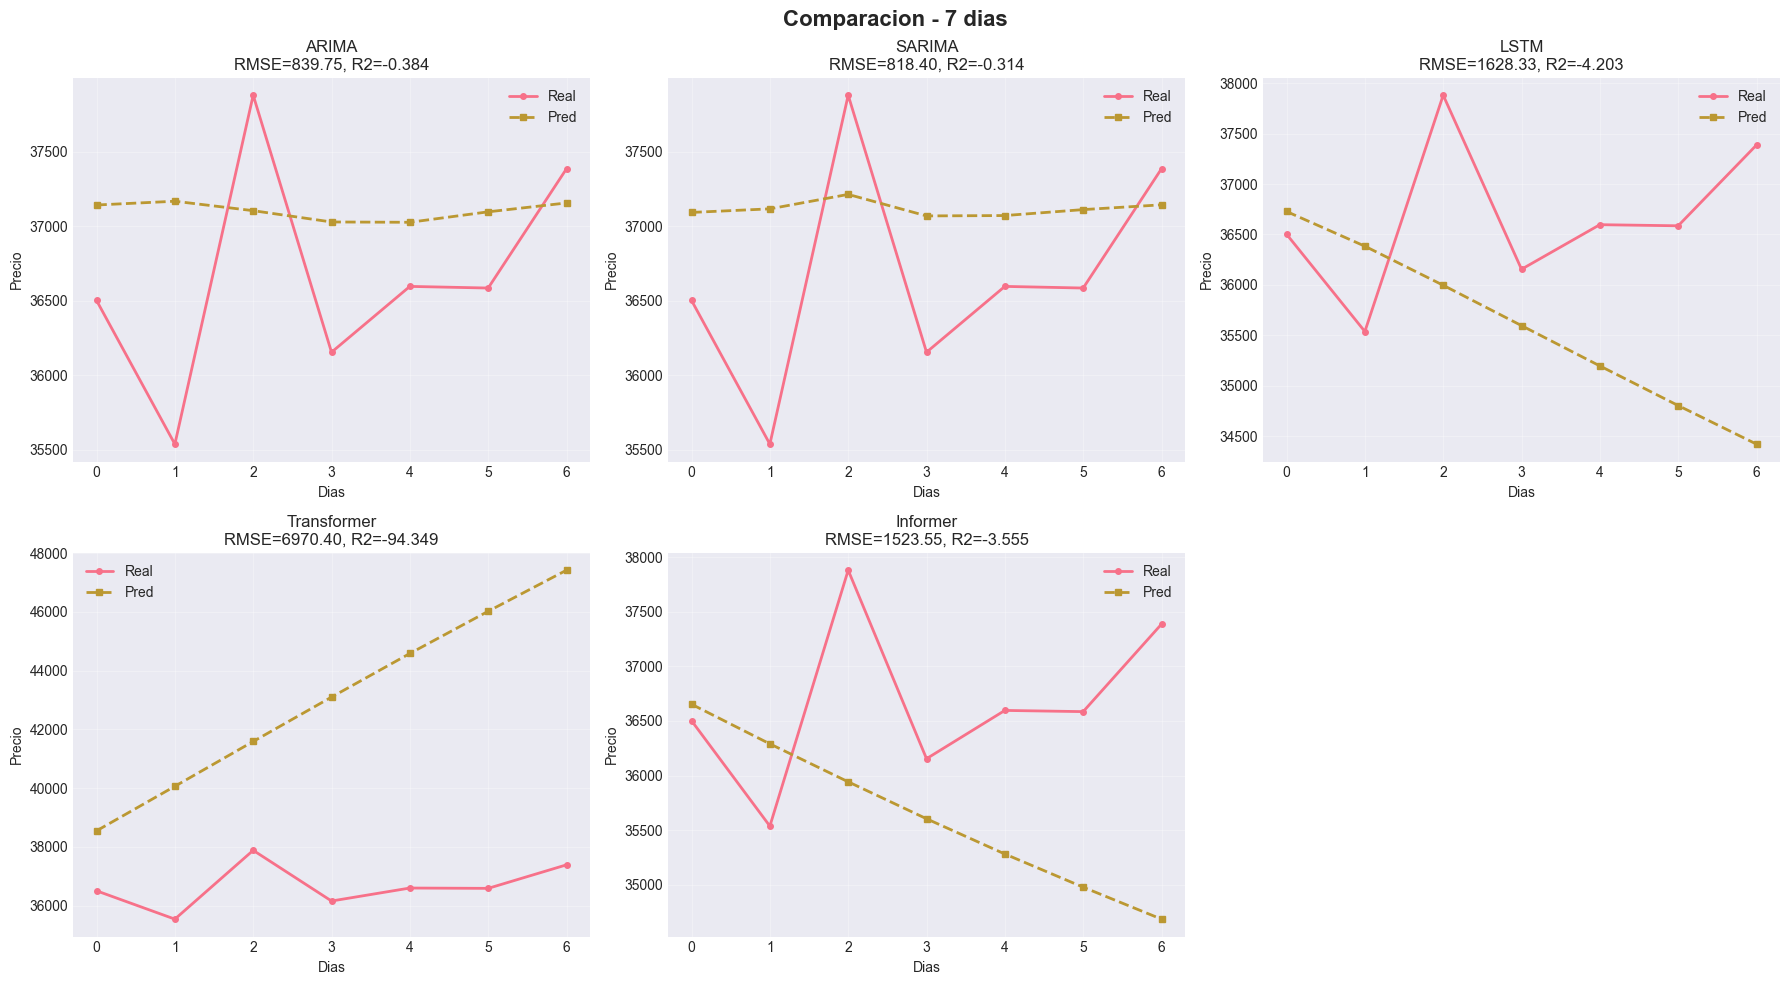

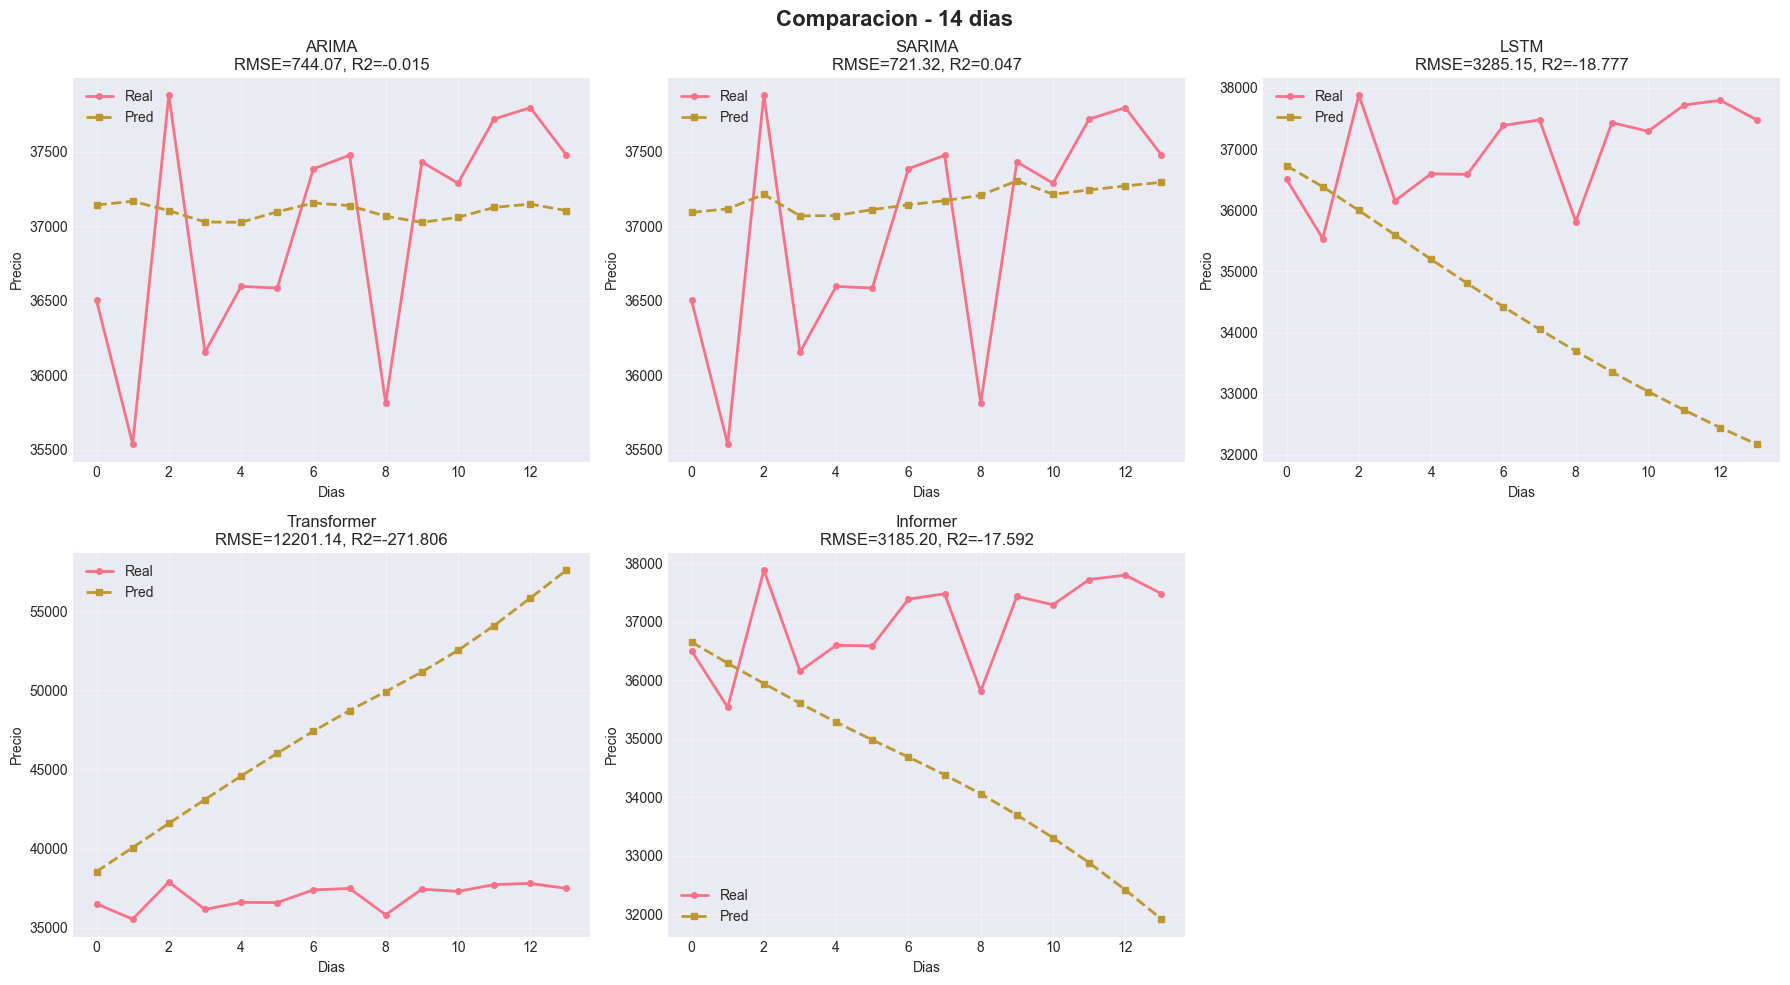

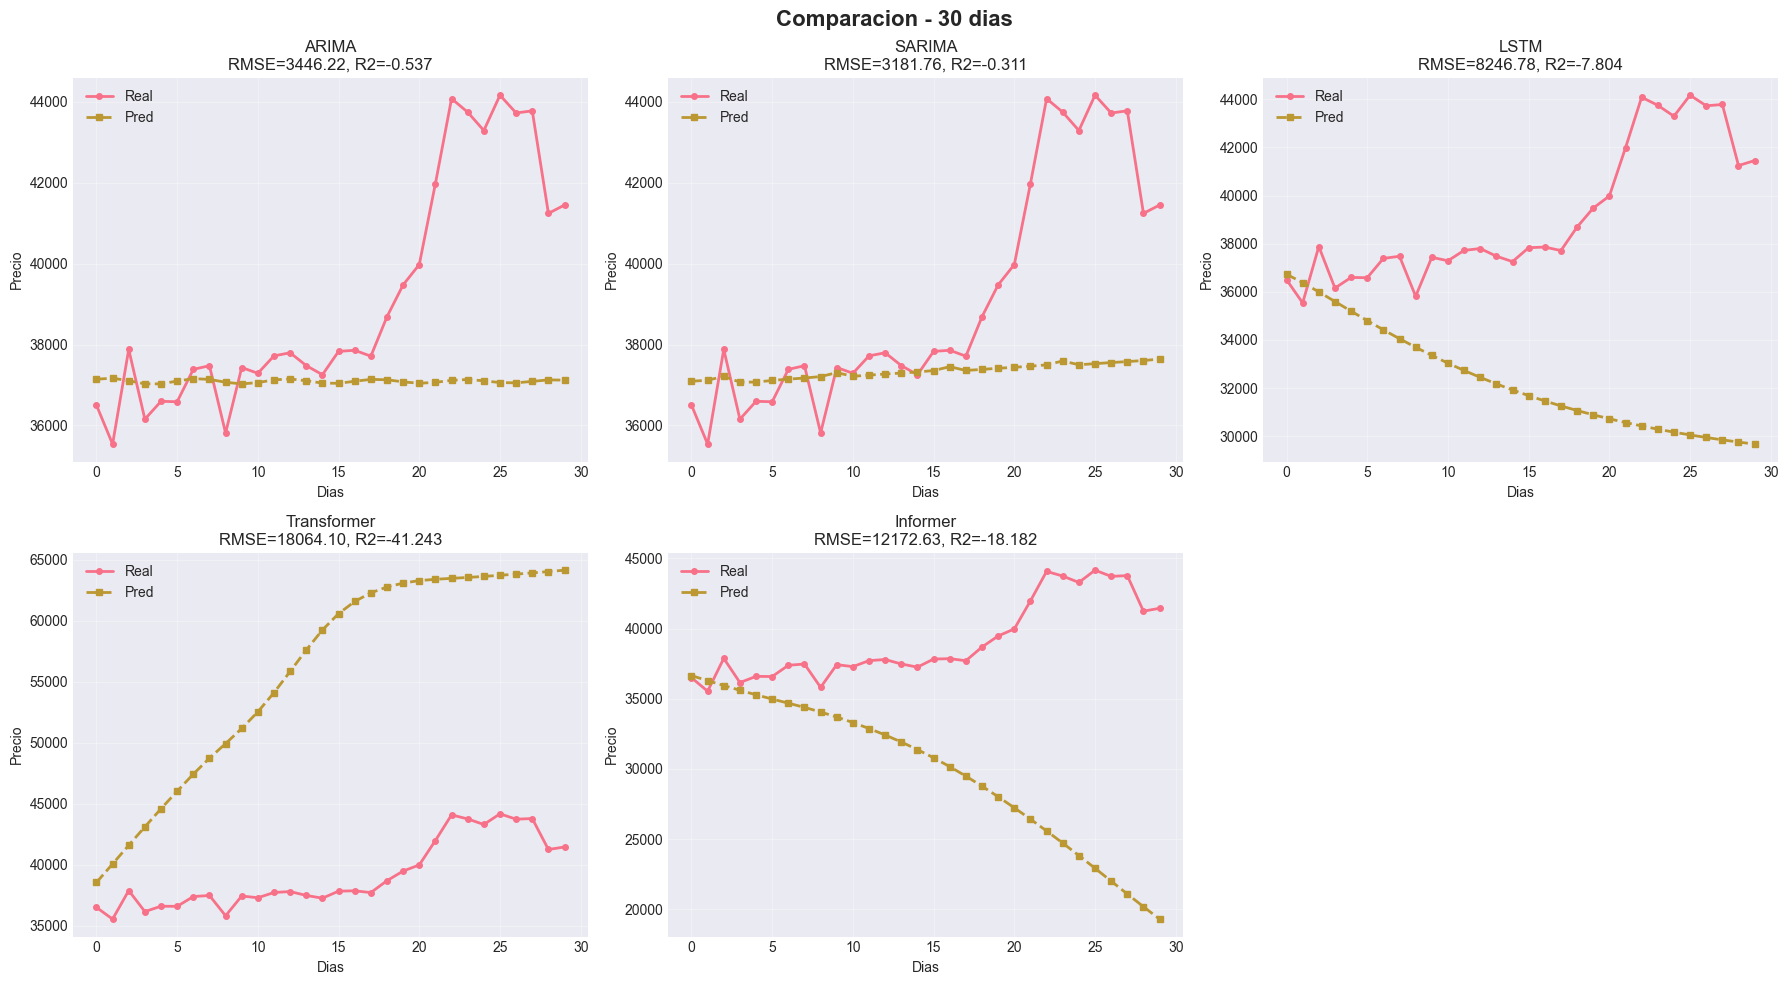


ANALISIS COMPLETO FINALIZADO
Resultados en: final_st2_results/


In [14]:
# Visualizacion
for horizon in CONFIG['forecast_horizons']:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Comparacion - {horizon} dias', fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    idx = 0
    for model_name, forecasts in all_results.items():
        if horizon in forecasts and idx < len(axes):
            ax = axes[idx]
            actual = forecasts[horizon]['actual']
            forecast = forecasts[horizon]['forecast']
            metrics = forecasts[horizon]['metrics']
            
            x = np.arange(len(actual))
            ax.plot(x, actual, 'o-', label='Real', linewidth=2, markersize=4)
            ax.plot(x, forecast, 's--', label='Pred', linewidth=2, markersize=4)
            ax.set_title(f"{model_name}\nRMSE={metrics['RMSE']:.2f}, R2={metrics['R2']:.3f}")
            ax.set_xlabel('Dias')
            ax.set_ylabel('Precio')
            ax.legend()
            ax.grid(True, alpha=0.3)
            idx += 1
    
    for i in range(idx, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/comparison_{horizon}d.png", dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*60)
print("ANALISIS COMPLETO FINALIZADO")
print(f"Resultados en: {CONFIG['output_dir']}/")
print("="*60)